# HUD homes demographic analysis
Research questions - <br>
How are neighborhoods where HUD homes are sold different from neighbourhoods that HUD homes aren't sold in terms of race, ethnicity and income? <br>
How are neighborhoods where HUD homes in Special Flood Hazard Areas (SFHAs) are differ from the other HUD homes in terms of race, ethnicity and income?

## Assembling dataset
- HUD's REO sales records beteween 01/01/2017 and 08/05/2020, that HUD released through NPR's Freedom of Information Act request
- List of HUD homes in SFHAs identified by NPR, methodology in separate spreadsheet
- Median household income in the past 12 months by census tract, from American Community Survey 2020 and 2019's 5-year data
- Number of residents by race and Hispanic origin by census tract,from American Community Survey 2020 and 2019's 5-year data
- Urban Area shapefiles from the Census Bureau

In [1]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import geopandas as gpd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import math
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import warnings

In [2]:
# ignore divide by zero warnings from NumPy.
np.seterr(divide='ignore')
# set Pandas row and column displays to maximum
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# choose workign directory
path = os.getcwd()
os.chdir(path)

In [3]:
# function for standardizing census tracts
def cutzero(x):
    if pd.isna(x) == True:
        return x
    else:
        return x.lstrip('0')

# fucntion for getting percentile
def get_percentile(x,y):
    if type(y) != list:
        return np.nan
    else:
        return stats.percentileofscore(y, x)

### HUD homes addresses

In [4]:
records = pd.read_excel('HUD_records_for_geocodio.xlsx')

In [5]:
for col in records.columns:
    records[col] = records[col].str.strip()
    
records.columns = records.columns.str.lower()

records['zip'] = [x[:5] for x in records.zip]
records.zip = records.zip.astype(int)

records = records.drop_duplicates()

In [6]:
records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 95566
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  95560 non-null  object
 1   city     95560 non-null  object
 2   state    95560 non-null  object
 3   zip      95560 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 3.3+ MB


### HUD homes in SFHAs
This is the results of Census Geocoder, Geocodio and ArcGIS's geocoder.

In [7]:
sfhahomes = pd.read_csv('20210115_hud_homes_in_sfhas_with_xy.csv')

In [8]:
sfhahomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3557 non-null   int64  
 1   address     3557 non-null   object 
 2   city        3557 non-null   object 
 3   state       3557 non-null   object 
 4   zip         3557 non-null   int64  
 5   fld_zone    3557 non-null   object 
 6   zone_subty  204 non-null    object 
 7   x           3557 non-null   float64
 8   y           3557 non-null   float64
 9   geocoder    3557 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 278.0+ KB


In [9]:
sfhahomes1 = sfhahomes[['address','city','state','zip']].copy().drop_duplicates()
sfhahomes1['sfha'] = 1

### HUD homes' census tracts
Load census geocoder results

In [10]:
tracts = pd.read_csv('20210610_census_tract_extract_master.csv')

In [11]:
tracts = tracts.drop('Unnamed: 0', axis = 1)
tracts = tracts.drop_duplicates()
# standarizing FIPS codes
tracts.STATE = [str(int(x)).zfill(2) if (pd.isna(x) == False) else x for x in tracts.STATE]
tracts.COUNTY = [str(int(x)).zfill(3) if (pd.isna(x) == False) else x for x in tracts.COUNTY]
tracts.TRACT = [str(int(x)) if (pd.isna(x) == False) else x for x in tracts.TRACT]

In [12]:
tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127207 entries, 0 to 127207
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   GEOID      94853 non-null   float64
 1   CENTLAT    94853 non-null   float64
 2   AREAWATER  94853 non-null   float64
 3   STATE      94853 non-null   object 
 4   BASENAME   94853 non-null   float64
 5   OID        94853 non-null   float64
 6   LSADC      94853 non-null   object 
 7   FUNCSTAT   94853 non-null   object 
 8   INTPTLAT   94853 non-null   float64
 9   NAME       94853 non-null   object 
 10  OBJECTID   94853 non-null   float64
 11  TRACT      94853 non-null   object 
 12  CENTLON    94853 non-null   float64
 13  AREALAND   94853 non-null   float64
 14  INTPTLON   94853 non-null   float64
 15  MTFCC      94853 non-null   object 
 16  COUNTY     94853 non-null   object 
 17  url        127207 non-null  object 
dtypes: float64(10), object(8)
memory usage: 18.4+ MB


### Urban designation of Census tracts
Loading all census tract boundary shapefiles for 2020.<br>
Downloaded state by state from here https://www2.census.gov/geo/tiger/TIGER2020/TRACT/ but later realized we can also download the latest national version from here https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html 

In [13]:
tract20list = [x for x in os.listdir('tractfiles20/') if (('shp' in x) & ('xml' not in x))]
tract20list = ['tractfiles20/' + x for x in tract20list]

In [14]:
tract20df = gpd.GeoDataFrame()

In [15]:
# the tract files are by state, so appending them to create a nationwisde geo dataframe.
for path in tract20list:
    file = gpd.read_file(path)
    tract20df = tract20df.append(file)

Loading the Urban Areas shapefile<br>
Download link https://www2.census.gov/geo/tiger/TIGER2020/UAC/

In [16]:
urban20 = gpd.read_file('census_urban_areas_tl_2020_us_uac10/tl_2020_us_uac10.shp')

Tried a few spatial joins including within and intersect, and intersect yields the most results and make 90% of all tract urban areas. that seems to be a better match than within, which makes a little above half of all tracts urban areas

In [17]:
tracturban20 = gpd.sjoin(tract20df,urban20, how = 'left', op = 'intersects' )

In [18]:
tracturban20_1 = tracturban20[pd.isna(tracturban20.UACE10) == False][['STATEFP','COUNTYFP','TRACTCE']].copy().drop_duplicates()
tracturban20_1['urban'] = True
tracturban20_1['vintage'] = 2020
# All tract codes will be stripped of leading zeros in this analysis b/c various geocoding results aren't consistent on this
tracturban20_1.TRACTCE = [x.lstrip('0') for x in tracturban20_1.TRACTCE]

In [19]:
tracturban20_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76789 entries, 0 to 31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   STATEFP   76789 non-null  object
 1   COUNTYFP  76789 non-null  object
 2   TRACTCE   76789 non-null  object
 3   urban     76789 non-null  bool  
 4   vintage   76789 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 3.0+ MB


### Census race/ethnicity data

In [20]:
racebytract = pd.read_csv('national_race_3_yrs_productDownload_2021-06-08T152933/ACSDT5Y2019.B03002_data_with_overlays_2021-06-08T152422.csv',low_memory=False)

In [21]:
racebytract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74002 entries, 0 to 74001
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GEO_ID       74002 non-null  object
 1   NAME         74002 non-null  object
 2   B03002_001E  74002 non-null  object
 3   B03002_001M  74002 non-null  object
 4   B03002_002E  74002 non-null  object
 5   B03002_002M  74002 non-null  object
 6   B03002_003E  74002 non-null  object
 7   B03002_003M  74002 non-null  object
 8   B03002_004E  74002 non-null  object
 9   B03002_004M  74002 non-null  object
 10  B03002_005E  74002 non-null  object
 11  B03002_005M  74002 non-null  object
 12  B03002_006E  74002 non-null  object
 13  B03002_006M  74002 non-null  object
 14  B03002_007E  74002 non-null  object
 15  B03002_007M  74002 non-null  object
 16  B03002_008E  74002 non-null  object
 17  B03002_008M  74002 non-null  object
 18  B03002_009E  74002 non-null  object
 19  B03002_009M  74002 non-nu

In [22]:
# dropping extraneous column
racebytract = racebytract.drop(0)
# extracting fips codes
racebytract['TRACT_GEOID'] = [x.split('US')[-1] for x in racebytract.GEO_ID]
racebytract['STATE'] = [x[:2] for x in racebytract.TRACT_GEOID]
racebytract['COUNTY'] = [x[2:5] for x in racebytract.TRACT_GEOID]
racebytract['TRACT'] = [x[5:].lstrip('0') for x in racebytract.TRACT_GEOID]
# calculating and extracting white percentage
racebytract.B03002_001E = racebytract.B03002_001E.astype(float)
racebytract.B03002_003E = racebytract.B03002_003E.astype(float)
racebytract['white_pct'] = racebytract.B03002_003E/racebytract.B03002_001E

In [23]:
racebytract1 = racebytract[['STATE','COUNTY','TRACT','white_pct']].copy().drop_duplicates()

### Merging data
Merge SFHA designation with HUD homes records

In [24]:
records1 = pd.merge(records, sfhahomes1, on = list(records.columns), how = 'left')
records1.sfha = [0 if pd.isna(x) == True else x for x in records1.sfha]
records1.zip = records1.zip.astype(str)
records1['url'] = ['https://geocoding.geo.census.gov/geocoder/geographies/address?street='+ x + '&city=' + y + '&state=' + z + '&zip=' + a + '&benchmark=4&vintage=4&format=json' for (x,y,z,a) in zip(records1.address, records1.city, records1.state, records1.zip)]

In [26]:
records1.sfha.value_counts()

0.0    92003
1.0     3557
Name: sfha, dtype: int64

Merge census tract code

In [29]:
records2 = pd.merge(records1, tracts, on = 'url', how = 'left')

In [30]:
len(records1)

95560

In [31]:
tractscnt = pd.DataFrame(records2.groupby('url').TRACT.count())

In [32]:
tractscnt = tractscnt.reset_index()
tractscnt[tractscnt.TRACT > 1]

,url,TRACT
19675,https://geocoding.geo.census.gov/geocoder/geog...,2
20250,https://geocoding.geo.census.gov/geocoder/geog...,2
32772,https://geocoding.geo.census.gov/geocoder/geog...,2
67159,https://geocoding.geo.census.gov/geocoder/geog...,2


In [33]:
list(tractscnt[tractscnt.TRACT > 1].url)

['https://geocoding.geo.census.gov/geocoder/geographies/address?street=1504 NORTH 17TH STR&city=FORT PIERCE&state=FL&zip=34950&benchmark=4&vintage=4&format=json',
 'https://geocoding.geo.census.gov/geocoder/geographies/address?street=1520 N SUMMIT AVE&city=DECATUR&state=IL&zip=62526&benchmark=4&vintage=4&format=json',
 'https://geocoding.geo.census.gov/geocoder/geographies/address?street=2102 BONIN RD&city=YOUNGSVILLE&state=LA&zip=70592&benchmark=4&vintage=4&format=json',
 'https://geocoding.geo.census.gov/geocoder/geographies/address?street=500 S MAHONING AVE&city=ALLIANCE&state=OH&zip=44601&benchmark=4&vintage=4&format=json']

4 addresses cross two tracts...assign all tracts where they have the higher AREALAND value. AREALAND is the area of the tract, not the portion of the address in the tract...picking the larger tract is a way to deconflict and increase likelihood that data from that tract will be larger

In [34]:
maxland = pd.DataFrame(records2.groupby('url').AREALAND.max())
maxland = maxland.reset_index()
maxland['maxland'] = True
maxland.head()

,url,AREALAND,maxland
0,https://geocoding.geo.census.gov/geocoder/geog...,NaN,True
1,https://geocoding.geo.census.gov/geocoder/geog...,NaN,True
2,https://geocoding.geo.census.gov/geocoder/geog...,NaN,True
3,https://geocoding.geo.census.gov/geocoder/geog...,NaN,True
4,https://geocoding.geo.census.gov/geocoder/geog...,NaN,True


In [35]:
records3 = pd.merge(records2, maxland, on = ['url','AREALAND'], how = 'left')

In [36]:
records3 = records3[records3.maxland == True]

In [37]:
records3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 115992
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    95560 non-null  object 
 1   city       95560 non-null  object 
 2   state      95560 non-null  object 
 3   zip        95560 non-null  object 
 4   sfha       95560 non-null  float64
 5   url        95560 non-null  object 
 6   GEOID      87956 non-null  float64
 7   CENTLAT    87956 non-null  float64
 8   AREAWATER  87956 non-null  float64
 9   STATE      87956 non-null  object 
 10  BASENAME   87956 non-null  float64
 11  OID        87956 non-null  float64
 12  LSADC      87956 non-null  object 
 13  FUNCSTAT   87956 non-null  object 
 14  INTPTLAT   87956 non-null  float64
 15  NAME       87956 non-null  object 
 16  OBJECTID   87956 non-null  float64
 17  TRACT      87956 non-null  object 
 18  CENTLON    87956 non-null  float64
 19  AREALAND   87956 non-null  float64
 20  INTPT

In [38]:
len(records3[pd.isna(records3.GEOID) == True])

7604

There are still a few thousand addresses for which we dont' have the census tracts codes for. Running them through Geocodio to fill in the blanks

Import Geocodio's census tract coding results

In [39]:
geocodio = pd.read_csv('20210610_census_tract_for_geocodio_geocodio_29560c1bfad083f765ff9a3b359f51d3cc44365f.csv')

In [40]:
len(geocodio[geocodio['Accuracy Score'] < .6])

2152

According to https://www.geocod.io/guides/accuracy-types-scores/, need to use the codes with lower than .6 accuracy score with caution. Tossing them out

In [41]:
geocodio2 = geocodio[geocodio['Accuracy Score'] >= .6].copy()
geocodio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5452 entries, 0 to 7597
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   address                            5452 non-null   object 
 1   city                               5452 non-null   object 
 2   state                              5452 non-null   object 
 3   zip                                5452 non-null   int64  
 4   Latitude                           5452 non-null   float64
 5   Longitude                          5452 non-null   float64
 6   Accuracy Score                     5452 non-null   float64
 7   Accuracy Type                      5452 non-null   object 
 8   Number                             3708 non-null   object 
 9   Street                             4101 non-null   object 
 10  Unit Type                          831 non-null    object 
 11  Unit Number                        877 non-null    objec

In [42]:
geocodio3 = geocodio2[['address','city','state','zip','State FIPS','County FIPS','Census Tract Code']].copy().drop_duplicates()

In [43]:
geocodio3.columns = ['address','city','state','zip','STATE','COUNTY','TRACT']
geocodio3.STATE = [str(int(x)).zfill(2) if pd.isna(x) == False else x for x in geocodio3.STATE]
geocodio3.COUNTY = [str(int(x))[-3:] if pd.isna(x) == False else x for x in geocodio3.COUNTY]
geocodio3.TRACT = [str(int(x)) if pd.isna(x) == False else x for x in geocodio3.TRACT]
geocodio3['zip'] = [str(x).zfill(5) for x in geocodio3['zip']]

In [44]:
geocodio3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5452 entries, 0 to 7597
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  5452 non-null   object
 1   city     5452 non-null   object
 2   state    5452 non-null   object
 3   zip      5452 non-null   object
 4   STATE    5452 non-null   object
 5   COUNTY   5452 non-null   object
 6   TRACT    5452 non-null   object
dtypes: object(7)
memory usage: 340.8+ KB


Clean up merged columns

In [45]:
records4 = records3[['address','city','state','zip','sfha','url','GEOID','STATE','TRACT','COUNTY']].copy().drop_duplicates()

In [46]:
records4['zip'] = [x.zfill(5) for x in records4['zip']]

Merge Geocodio census tract coding results

In [47]:
records5 = pd.merge(records4,geocodio3, on = ['address','city','state','zip'], how = 'left')

In [48]:
records5['STATE'] = [x if pd.isna(x) == False else y for (x,y) in zip(records5.STATE_x, records5.STATE_y)]
records5['TRACT'] = [x if pd.isna(x) == False else y for (x,y) in zip(records5.TRACT_x, records5.TRACT_y)]
records5['COUNTY'] = [x if pd.isna(x) == False else y for (x,y) in zip(records5.COUNTY_x, records5.COUNTY_y)]

In [49]:
records5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 95559
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   address   95560 non-null  object 
 1   city      95560 non-null  object 
 2   state     95560 non-null  object 
 3   zip       95560 non-null  object 
 4   sfha      95560 non-null  float64
 5   url       95560 non-null  object 
 6   GEOID     87956 non-null  float64
 7   STATE_x   87956 non-null  object 
 8   TRACT_x   87956 non-null  object 
 9   COUNTY_x  87956 non-null  object 
 10  STATE_y   5451 non-null   object 
 11  COUNTY_y  5451 non-null   object 
 12  TRACT_y   5451 non-null   object 
 13  STATE     93407 non-null  object 
 14  TRACT     93407 non-null  object 
 15  COUNTY    93407 non-null  object 
dtypes: float64(2), object(14)
memory usage: 12.4+ MB


Merging ACS race/ethnicity data

In [50]:
records6 = pd.merge(records5, racebytract1, on = ['STATE','COUNTY','TRACT'], how = 'left')

In [51]:
records6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 95559
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    95560 non-null  object 
 1   city       95560 non-null  object 
 2   state      95560 non-null  object 
 3   zip        95560 non-null  object 
 4   sfha       95560 non-null  float64
 5   url        95560 non-null  object 
 6   GEOID      87956 non-null  float64
 7   STATE_x    87956 non-null  object 
 8   TRACT_x    87956 non-null  object 
 9   COUNTY_x   87956 non-null  object 
 10  STATE_y    5451 non-null   object 
 11  COUNTY_y   5451 non-null   object 
 12  TRACT_y    5451 non-null   object 
 13  STATE      93407 non-null  object 
 14  TRACT      93407 non-null  object 
 15  COUNTY     93407 non-null  object 
 16  white_pct  73954 non-null  float64
dtypes: float64(3), object(14)
memory usage: 13.1+ MB


Over 20,000 addresses don't have a  white percentage associated with them. This suggests that some of the addresses might have the wrong census tracts, and this could be because they were geodocoded inaccurately.<br>

First try at filling missing values - using geocodio's lat long<br>

Passing the addresses that don't have a white pct, haven't been coded in Geocodio and but has been coded with Census (and Geodocodio return a null result b/c it didn't get joined in the last iteration) through Geocodio again

In [52]:
codiosecondpass = records6[(pd.isna(records6.white_pct) == True) &
        (pd.isna(records6.STATE_y) == True) & 
        (pd.isna(records6.STATE_x) == False)][['address','city','state','zip']].copy()

In [53]:
codiosecondpass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18263 entries, 27 to 95549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  18263 non-null  object
 1   city     18263 non-null  object
 2   state    18263 non-null  object
 3   zip      18263 non-null  object
dtypes: object(4)
memory usage: 713.4+ KB


Importing Geocodio's coordinate geocoding results we've got previously

In [54]:
codio = pd.read_csv('HUD_records_for_geocodio_geocodio_f802edffd7f9a777c6823662d86761228bf2fa3f.csv')

In [55]:
codio.columns = codio.columns.str.lower()
codio.columns = codio.columns.str.replace(' ','_')

In [56]:
codio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95567 entries, 0 to 95566
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   address         95567 non-null  object 
 1   city            95567 non-null  object 
 2   state           95567 non-null  object 
 3   zip             95567 non-null  object 
 4   latitude        95567 non-null  float64
 5   longitude       95567 non-null  float64
 6   accuracy_score  95567 non-null  float64
 7   accuracy_type   95566 non-null  object 
 8   number          90559 non-null  object 
 9   street          91666 non-null  object 
 10  unit_type       2076 non-null   object 
 11  unit_number     2324 non-null   object 
 12  city.1          95565 non-null  object 
 13  state.1         95565 non-null  object 
 14  county          95565 non-null  object 
 15  zip             95566 non-null  float64
 16  country         95566 non-null  object 
 17  source          95566 non-null 

In [57]:
codio1 = codio[codio.accuracy_score >= .6].copy()
codio_copy = codio.iloc[:,:6].copy().drop_duplicates()

In [58]:
codio_copy.head()

,address,city,state,zip,latitude,longitude
0,700 18TH PL SW ...,BIRMINGHAM,AL,35211-0000,33.483621,-86.867248
1,3765 NARROW LANE RD ...,MONTGOMERY,AL,36111-0000,32.336461,-86.281893
2,2125-27 ARLINGTON A ...,BESSEMER,AL,35020-0000,33.402981,-86.946330
3,3349 HERBERT DRIVE ...,MONTGOMERY,AL,36116-0000,32.302026,-86.270992
4,3101 AVENUE H ...,BIRMINGHAM,AL,35218-0000,33.501075,-86.901505


In [59]:
codio_copy.zip = [x.split('-')[0] for x in codio_copy.zip]

# strip whitespaces
df_obj1 = codio_copy.select_dtypes(['object'])
for col in df_obj1.columns:
    codio_copy[col] = codio_copy[col].str.strip()
    
#make sure all zip5 are 5 digits   
codio_copy['zip'] = codio_copy['zip'].str.zfill(5)

In [60]:
codio2 = codio1.iloc[:,:6].copy().drop_duplicates()

In [61]:
codio2.zip = [x.split('-')[0] for x in codio2.zip]
# strip whitespaces
df_obj = codio2.select_dtypes(['object'])
for col in df_obj.columns:
    codio2[col] = codio2[col].str.strip()
#make sure all zip5 are 5 digits   
codio2['zip'] = codio2['zip'].str.zfill(5)

In [62]:
codiosecondpass['redo'] = True

In [63]:
codio3 = pd.merge(codio2,codiosecondpass, on = ['address','city','state','zip'], how = 'outer')

In [64]:
codio3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93209 entries, 0 to 93208
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    93209 non-null  object 
 1   city       93209 non-null  object 
 2   state      93209 non-null  object 
 3   zip        93209 non-null  object 
 4   latitude   92961 non-null  float64
 5   longitude  92961 non-null  float64
 6   redo       18263 non-null  object 
dtypes: float64(2), object(5)
memory usage: 5.7+ MB


In [65]:
print('Count of addresses that are in the seocondpass df but not in codio2 df')
len(codio3[pd.isna(codio3.latitude) == True])

Count of addresses that are in the seocondpass df but not in codio2 df


248

Why is that? maybe their accuracy score is too low?

In [66]:
codio_check = pd.merge(codio_copy,codiosecondpass, on = ['address','city','state','zip'], how = 'outer')

In [67]:
codio_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95561 entries, 0 to 95560
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    95561 non-null  object 
 1   city       95561 non-null  object 
 2   state      95561 non-null  object 
 3   zip        95561 non-null  object 
 4   latitude   95561 non-null  float64
 5   longitude  95561 non-null  float64
 6   redo       18263 non-null  object 
dtypes: float64(2), object(5)
memory usage: 5.8+ MB


In [68]:
print('Count of addresses that are in second pass but not in original codio df')
len(codio_check[pd.isna(codio_check.latitude) == True])

Count of addresses that are in second pass but not in original codio df


0

Yep. so they effectively don't have a lat long we can use...ignore.

Next...running those that need redoing with the census boundary files.

In [69]:
codio4 = codio3[pd.isna(codio3.latitude) == False].copy().drop_duplicates()

In [70]:
codio4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92960 entries, 0 to 92960
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    92960 non-null  object 
 1   city       92960 non-null  object 
 2   state      92960 non-null  object 
 3   zip        92960 non-null  object 
 4   latitude   92960 non-null  float64
 5   longitude  92960 non-null  float64
 6   redo       18015 non-null  object 
dtypes: float64(2), object(5)
memory usage: 5.7+ MB


In [71]:
secondpass2 = codio4[codio4.redo == True].copy()

Tried merging secondpass2 with 2020 tractfiles and it didn't manage to fill in the null. When merging with the 2019 tract shapefiles, though, almost all the nulls have been filled. Process and results below.<br>
2019 shapefiles download link https://www2.census.gov/geo/tiger/TIGER2019/TRACT/

In [72]:
# loading all tract boundary shapefiles 
tractlist = [x for x in os.listdir('tractfiles19/') if (('shp' in x) & ('xml' not in x))]
tractlist = ['tractfiles19/' + x for x in tractlist]

In [73]:
tractdf = gpd.GeoDataFrame()

In [74]:
for path in tractlist:
    file = gpd.read_file(path)
    tractdf = tractdf.append(file)

In [75]:
gdf = gpd.GeoDataFrame(
    secondpass2, geometry=gpd.points_from_xy(secondpass2.longitude, secondpass2.latitude))

In [76]:
gdf.head()

,address,city,state,zip,latitude,longitude,redo,geometry
26,513 LLOYD NOLAND PKWY,FAIRFIELD,AL,35064,33.488587,-86.909608,True,POINT (-86.90961 33.48859)
36,1613 MARALYN DR,BIRMINGHAM,AL,35235,33.631186,-86.655724,True,POINT (-86.65572 33.63119)
40,3825 3RD AVE,TUSCALOOSA,AL,35405,33.173358,-87.540152,True,POINT (-87.54015 33.17336)
43,13325 JACQUELINE DR,MCCALLA,AL,35111,33.285931,-87.143047,True,POINT (-87.14305 33.28593)
51,412 KERRI DR,BIRMINGHAM,AL,35215,33.634932,-86.673914,True,POINT (-86.67391 33.63493)


In [77]:
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:4269")

In [78]:
trymerge = gpd.sjoin(gdf, tractdf, how = 'left', op = 'within')

In [79]:
trymerge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18015 entries, 26 to 92959
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      18015 non-null  object  
 1   city         18015 non-null  object  
 2   state        18015 non-null  object  
 3   zip          18015 non-null  object  
 4   latitude     18015 non-null  float64 
 5   longitude    18015 non-null  float64 
 6   redo         18015 non-null  object  
 7   geometry     18015 non-null  geometry
 8   index_right  18013 non-null  float64 
 9   STATEFP      18013 non-null  object  
 10  COUNTYFP     18013 non-null  object  
 11  TRACTCE      18013 non-null  object  
 12  GEOID        18013 non-null  object  
 13  NAME         18013 non-null  object  
 14  NAMELSAD     18013 non-null  object  
 15  MTFCC        18013 non-null  object  
 16  FUNCSTAT     18013 non-null  object  
 17  ALAND        18013 non-null  float64 
 18  AWATER       1801

In [80]:
trymerge['TRACTCE'] = [cutzero(x) for x in trymerge.TRACTCE] 

In [81]:
fillnull = pd.merge(trymerge, racebytract1, left_on = ['STATEFP','COUNTYFP','TRACTCE'], right_on = ['STATE','COUNTY','TRACT'], how = 'left')

In [82]:
fillnull.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18015 entries, 0 to 18014
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      18015 non-null  object  
 1   city         18015 non-null  object  
 2   state        18015 non-null  object  
 3   zip          18015 non-null  object  
 4   latitude     18015 non-null  float64 
 5   longitude    18015 non-null  float64 
 6   redo         18015 non-null  object  
 7   geometry     18015 non-null  geometry
 8   index_right  18013 non-null  float64 
 9   STATEFP      18013 non-null  object  
 10  COUNTYFP     18013 non-null  object  
 11  TRACTCE      18013 non-null  object  
 12  GEOID        18013 non-null  object  
 13  NAME         18013 non-null  object  
 14  NAMELSAD     18013 non-null  object  
 15  MTFCC        18013 non-null  object  
 16  FUNCSTAT     18013 non-null  object  
 17  ALAND        18013 non-null  float64 
 18  AWATER       18013

In [83]:
fillnull2 = fillnull[['address','city','state','zip','STATEFP','COUNTYFP','TRACTCE','white_pct']].copy()
fillnull2['vintage'] = 2019

Cleaning up the columns

In [84]:
records7 = records6[[x for x in records6.columns if (('_x' not in x) & ('_y' not in x)) ]]
records7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 95559
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    95560 non-null  object 
 1   city       95560 non-null  object 
 2   state      95560 non-null  object 
 3   zip        95560 non-null  object 
 4   sfha       95560 non-null  float64
 5   url        95560 non-null  object 
 6   GEOID      87956 non-null  float64
 7   STATE      93407 non-null  object 
 8   TRACT      93407 non-null  object 
 9   COUNTY     93407 non-null  object 
 10  white_pct  73954 non-null  float64
dtypes: float64(3), object(8)
memory usage: 8.7+ MB


In [85]:
records8 = pd.merge(records7,fillnull2, left_on = ['address','city','state','zip'], right_on = ['address','city','state','zip'], how = 'left')

In [86]:
records8['white_pct'] = [x if pd.isna(x) == False else y for (x,y) in zip(records8.white_pct_x, records8.white_pct_y)]

In [87]:
records8.vintage = [2020 if pd.isna(x) == True else x for x in records8.vintage]

In [88]:
records8['county1'] = [y if pd.isna(y) == False else x for (x,y) in zip(records8.COUNTY, records8.COUNTYFP)]
records8['state1'] = [y if pd.isna(y) == False else x for (x,y) in zip(records8.STATE, records8.STATEFP)]
records8['tract1'] = [y if pd.isna(y) == False else x for (x,y) in zip(records8.TRACT, records8.TRACTCE)]
records8.county1 = [str(int(x)).zfill(3)[-3:] if pd.isna(x) == False else np.nan for x in records8.county1]
records8.state1 = [str(int(x)).zfill(2) if pd.isna(x) == False else np.nan for x in records8.state1]
records8.tract1 = [str(int(x)) if pd.isna(x) == False else np.nan for x in records8.tract1]

In [89]:
records8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95560 entries, 0 to 95559
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   address      95560 non-null  object 
 1   city         95560 non-null  object 
 2   state        95560 non-null  object 
 3   zip          95560 non-null  object 
 4   sfha         95560 non-null  float64
 5   url          95560 non-null  object 
 6   GEOID        87956 non-null  float64
 7   STATE        93407 non-null  object 
 8   TRACT        93407 non-null  object 
 9   COUNTY       93407 non-null  object 
 10  white_pct_x  73954 non-null  float64
 11  STATEFP      18013 non-null  object 
 12  COUNTYFP     18013 non-null  object 
 13  TRACTCE      18013 non-null  object 
 14  white_pct_y  18013 non-null  float64
 15  vintage      95560 non-null  float64
 16  white_pct    91967 non-null  float64
 17  county1      93407 non-null  object 
 18  state1       93407 non-null  object 
 19  trac

Rural vs urban status is going to be a big factor here. We can't compare homes in LA with anywhere else in the county. So need to code census tracts by rural/urban and need to correspond by vintage.<br>
Urban area reference from the Census https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural/2010-urban-rural.html

Generating county level arrays to compare the tract to

Merge urban designation

In [90]:
tracturban20_1.urban = [1 if x == True else x == False for x in tracturban20_1.urban ]

In [91]:
records9 = pd.merge(records8, tracturban20_1, left_on = ['state1','county1','tract1'], right_on = ['STATEFP','COUNTYFP','TRACTCE'], how = 'left')

In [92]:
records9.urban = [0 if pd.isna(x) == True else x for x in records9.urban ]

In [93]:
racebytract2 = pd.merge(racebytract1,tracturban20_1, left_on = ['STATE','COUNTY','TRACT'], right_on  = ['STATEFP','COUNTYFP','TRACTCE'], how = 'left')

In [94]:
racebytract2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74001 entries, 0 to 74000
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATE      74001 non-null  object 
 1   COUNTY     74001 non-null  object 
 2   TRACT      74001 non-null  object 
 3   white_pct  73298 non-null  float64
 4   STATEFP    56129 non-null  object 
 5   COUNTYFP   56129 non-null  object 
 6   TRACTCE    56129 non-null  object 
 7   urban      56129 non-null  float64
 8   vintage    56129 non-null  float64
dtypes: float64(3), object(6)
memory usage: 5.6+ MB


In [95]:
racebytract2.urban = [0 if pd.isna(x) == True else x for x in racebytract2.urban]

In [96]:
racebytract2.urban.value_counts()

1.0    56129
0.0    17872
Name: urban, dtype: int64

In [97]:
racebycounty = racebytract2.groupby(['STATE','COUNTY','urban']).agg(lambda white_pct: white_pct.tolist() )
racebycounty1 = racebycounty[['white_pct']]
racebycounty1 = racebycounty1.reset_index()
racebycounty1.columns = [x + '_array_urban' for x in racebycounty1.columns]
racebycounty1['length_array'] = [len(x) if type(x) == list else np.nan for x in racebycounty1.white_pct_array_urban]

In [98]:
racebycounty1.urban_array_urban.value_counts()

0.0    3014
1.0    2441
Name: urban_array_urban, dtype: int64

In [99]:
records10 = pd.merge(records9,racebycounty1, left_on = ['state1','county1','urban'], 
                     right_on = ['STATE_array_urban','COUNTY_array_urban','urban_array_urban'], how = 'left')

In [100]:
records10['white_county_percentile_urban'] = [get_percentile(x,y) for (x,y) in zip(records10.white_pct, records10.white_pct_array_urban)]

Load income data

In [101]:
incomebytract = pd.read_csv('census_median_household_income_2019_ACSDT5Y2019.B19013_2021-07-16T111131/ACSDT5Y2019.B19013_data_with_overlays_2021-07-16T110938.csv')

In [102]:
incomebytract.columns = ['GEO_ID','NAME','median_household_income','median_household_income_moe']
incomebytract = incomebytract.drop(0)
incomebytract['STATE_income'] = [x.split('US')[-1][:2] for x in incomebytract.GEO_ID]
incomebytract['COUNTY_income'] = [x.split('US')[-1][2:5] for x in incomebytract.GEO_ID]
incomebytract['TRACT_income'] = [x.split('US')[-1][5:] for x in incomebytract.GEO_ID]
incomebytract1 = incomebytract[['STATE_income','COUNTY_income','TRACT_income','median_household_income']].copy().drop_duplicates()

In [103]:
def clean_census(x):
    if x == '250,000+':
        return 250000
    if x == '2,500-':
        return 2500
    if x == '-':
        return np.nan
    else:
        return float(x)

In [104]:
incomebytract1.median_household_income = [clean_census(x) for x in incomebytract1.median_household_income]
# note - outlying values include'-', '2,500-' and '250,000+'

In [105]:
incomebytract1.TRACT_income = [cutzero(x) for x in incomebytract1.TRACT_income]

Merge income data

In [106]:
records11 = pd.merge(records10, incomebytract1, left_on = ['state1','county1','tract1'], right_on = ['STATE_income','COUNTY_income','TRACT_income'], how = 'left')

Income data by county

In [107]:
incomebytract2 = pd.merge(incomebytract1, tracturban20_1, left_on = ['STATE_income','COUNTY_income','TRACT_income'],right_on = ['STATEFP','COUNTYFP','TRACTCE'], how = 'left')
incomebytract2.urban = [x if pd.isna(x) == False else 0 for x in incomebytract2.urban]

In [108]:
incomebycounty = incomebytract2.groupby(['STATE_income','COUNTY_income','urban']).agg(lambda median_household_income: median_household_income.tolist())
incomebycounty1 = incomebycounty['median_household_income'].copy()
incomebycounty1 = incomebycounty1.reset_index()
incomebycounty1.columns = [x + '_array' for x in incomebycounty1.columns]
incomebycounty1['income_array_length'] = [len(x) for x in incomebycounty1.median_household_income_array]

Merging records with income countylevel array

In [109]:
records12 = pd.merge(records11, incomebycounty1, left_on = ['state1','county1','urban'], right_on = ['STATE_income_array','COUNTY_income_array','urban_array'], how = 'left')

In [110]:
records12['income_county_percentile_urban'] = [get_percentile(x,y) for (x,y) in zip(records12.median_household_income, records12.median_household_income_array)]

# Analysis

## How are tracts were HUD homes are different from the rest of the country?
### Median household income

In [111]:
# labelling the tracts where HUD homes are sold
records12tracts = records12[['state1','county1','tract1']].copy().drop_duplicates()
records12tracts['HUD'] = 1

In [112]:
# Putting the HUD label on census income dataset
incomebytract3 = pd.merge(incomebytract2, records12tracts, left_on = ['STATE_income','COUNTY_income','TRACT_income'],right_on = ['state1','county1','tract1'], how = 'left')
incomebytract3['HUD'] = [x if x == 1 else 0 for x in incomebytract3['HUD'] ]

In [113]:
incomebytract3['log_income'] = [np.log(x) for x in incomebytract3.median_household_income]

In [114]:
# statistical test for equal variance
levene(incomebytract3[(pd.isna(incomebytract3.log_income)== False) & (incomebytract3.HUD == 0) ].log_income, 
       incomebytract3[(pd.isna(incomebytract3.log_income)== False)& (incomebytract3.HUD == 1)].log_income)

LeveneResult(statistic=2803.276016951986, pvalue=0.0)

In [115]:
# statistical test for equal variance
levene(incomebytract3[(pd.isna(incomebytract3.median_household_income)== False) & (incomebytract3.HUD == 0) ].median_household_income, 
       incomebytract3[(pd.isna(incomebytract3.median_household_income)== False)& (incomebytract3.HUD == 1)].median_household_income)

LeveneResult(statistic=4928.551643563101, pvalue=0.0)

In [116]:
print('Descriptive statistics on median household income of census tracts by HUD home sales status and urban area, 2017-2020')
incomebytract3.groupby(['urban','HUD']).median_household_income.describe()

Descriptive statistics on median household income of census tracts by HUD home sales status and urban area, 2017-2020


count          mean           std      min       25%      50%  \
urban HUD                                                                    
0.0   0.0   7838.0  67582.445522  32356.642550   4129.0  45180.75  60273.0   
      1.0   9487.0  59044.859703  20642.705401  12955.0  44803.50  55345.0   
1.0   0.0  29762.0  76635.403938  40392.814029   2500.0  47815.50  68835.0   
      1.0  24945.0  58568.921387  24272.993345   7859.0  41637.00  54141.0   

               75%       max  
urban HUD                     
0.0   0.0  83445.5  250000.0  
      1.0  68774.5  188813.0  
1.0   0.0  97188.0  250000.0  
      1.0  70788.0  250000.0

In [117]:
print ('In urban areas, do the income of tracts with HUD homes differ from those without?')
mannwhitneyu(incomebytract3[(incomebytract3.HUD == 0) &
                           (incomebytract3.urban == 1) & 
              (pd.isna(incomebytract3.median_household_income) == False)].median_household_income, 
       incomebytract3[(incomebytract3.HUD == 1) &
                           (incomebytract3.urban == 1) & 
              (pd.isna(incomebytract3.median_household_income) == False)].median_household_income)[1]<.05

In urban areas, do the income of tracts with HUD homes differ from those without?


True

In [118]:
print ('In rural areas, do the income of tracts with HUD homes differ from those without?')
mannwhitneyu(incomebytract3[(incomebytract3.HUD == 0) &
                           (incomebytract3.urban == 0) & 
              (pd.isna(incomebytract3.median_household_income) == False)].median_household_income, 
       incomebytract3[(incomebytract3.HUD == 1) &
                           (incomebytract3.urban == 0) & 
              (pd.isna(incomebytract3.median_household_income) == False)].median_household_income)[1]<.05

In rural areas, do the income of tracts with HUD homes differ from those without?


True

We can see that the census tracts where HUD homes have been sold recently have lower median household income than the census tracts where no HUD homes have been sold<br>
#### State by state analysis

In [119]:
income_rural_list = []

In [120]:
incomebytract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73056 entries, 1 to 73056
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   GEO_ID                       73056 non-null  object
 1   NAME                         73056 non-null  object
 2   median_household_income      73056 non-null  object
 3   median_household_income_moe  73056 non-null  object
 4   STATE_income                 73056 non-null  object
 5   COUNTY_income                73056 non-null  object
 6   TRACT_income                 73056 non-null  object
dtypes: object(7)
memory usage: 4.5+ MB


In [121]:
for state in list(incomebytract3.STATE_income.unique()):
    dicti = {}
    dicti['statefp'] = state
    try:
        f1,p1 = mannwhitneyu(incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 0) &
                                            (incomebytract3.urban == 0) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income, 
                             incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 1) &
                                            (incomebytract3.urban == 0) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income)
        f2,p2 = mannwhitneyu(incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 0) &
                                            (incomebytract3.urban == 1) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income, 
                             incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 1) &
                                            (incomebytract3.urban == 1) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_HUD_median'] = incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 1) &
                                            (incomebytract3.urban == 1) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income.median()
        dicti['urban_non_HUD_median'] = incomebytract3[(incomebytract3.STATE_income == state)& 
                                            (incomebytract3.HUD == 0) &
                                            (incomebytract3.urban == 1) & 
                                            (pd.isna(incomebytract3.median_household_income) == False)].median_household_income.median()
        dicti['rural_HUD_median'] = incomebytract3[(incomebytract3.STATE_income == state)& 
                                                   (incomebytract3.HUD == 1) &
                                                   (incomebytract3.urban == 0) & 
                                                   (pd.isna(incomebytract3.median_household_income) == False)].median_household_income.median()
        dicti['rural_non_HUD_median'] = incomebytract3[(incomebytract3.STATE_income == state)& 
                                                       (incomebytract3.HUD == 0) &
                                                       (incomebytract3.urban == 0) & 
                                                       (pd.isna(incomebytract3.median_household_income) == False)].median_household_income.median()
        income_rural_list.append(dicti)
    except Exception:
        income_rural_list.append(dicti)

In [122]:
income_rural_df = pd.DataFrame(income_rural_list)
income_rural_df['urban_diff'] = income_rural_df.urban_non_HUD_median/income_rural_df.urban_HUD_median-1
income_rural_df['rural_diff'] = income_rural_df.rural_non_HUD_median/income_rural_df.rural_HUD_median-1
income_rural_df['urban_005'] = [True if x <.05 else False for x in income_rural_df.urban_p]
income_rural_df['rural_005'] = [True if x <.05 else False for x in income_rural_df.rural_p]

In [123]:
# source of FIPS codes and state abbreviation https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
statenames = pd.read_excel('fips_statename_crosswalk.xlsx')
statenames.FIPS = [str(int(x)).zfill(2) for x in statenames.FIPS]

In [124]:
income_rural_df1 = pd.merge(income_rural_df, statenames, left_on = 'statefp', right_on = 'FIPS', how = 'left')

In [125]:
income_rural_df1

,statefp,rural_p,urban_p,urban_HUD_median,urban_non_HUD_median,rural_HUD_median,rural_non_HUD_median,urban_diff,rural_diff,urban_005,rural_005,Name,Postal Code,FIPS
0,01,1.110914e-08,1.164405e-01,45000.0,40076.0,49579.5,39728.5,-0.109422,-0.198691,False,True,Alabama,AL,01
1,02,1.089554e-01,1.018560e-01,80405.0,82475.0,68984.0,59375.0,0.025745,-0.139293,False,False,Alaska,AK,02
2,04,2.570059e-01,7.662943e-09,51442.0,60679.0,52905.5,56920.5,0.179561,0.075890,True,False,Arizona,AZ,04
3,05,7.041131e-03,7.072397e-02,46648.0,42723.0,45957.0,41862.5,-0.084141,-0.089094,False,True,Arkansas,AR,05
4,06,3.808859e-11,3.924182e-44,59822.5,76790.0,60190.5,74167.0,0.283631,0.232204,True,True,California,CA,06
5,08,1.856153e-05,1.002677e-23,57605.0,78000.0,61034.0,76034.0,0.354049,0.245765,True,True,Colorado,CO,08
6,09,4.176596e-02,3.357711e-18,75110.0,122633.0,79707.0,89701.0,0.632712,0.125384,True,True,Connecticut,CT,09
7,10,1.781562e-01,6.906865e-06,57846.5,77708.0,67000.0,74526.0,0.343348,0.112328,True,False,Delaware,DE,10
8,11,4.791754e-01,3.620237e-03,58894.0,94823.5,105434.0,105550.5,0.610071,0.001105,True,False,NaN,NaN,NaN
9,12,1.251396e-03,2.494209e-20,50604.0,57844.0,53686.5,57976.0,0.143072,0.079899,True,True,Florida,FL,12


In [126]:
# comparing to other tracts in the same county
incomebytract4 = pd.merge(incomebytract3, incomebycounty1, left_on = ['STATE_income','COUNTY_income','urban'],
                         right_on = ['STATE_income_array','COUNTY_income_array','urban_array'], how = 'left')

In [127]:
incomebytract4['county_percentile'] = [get_percentile(x,y) for (x,y) in zip(incomebytract4.median_household_income,incomebytract4.median_household_income_array)]

In [128]:
incomebytract4.groupby(['urban','HUD']).county_percentile.describe()

count       mean        std       min        25%        50%  \
urban HUD                                                                  
0.0   0.0   7838.0  57.177475  30.211233  0.304878  33.115619  57.142857   
      1.0   9487.0  57.504915  28.451266  1.020408  33.333333  56.250000   
1.0   0.0  29762.0  52.807237  29.876944  0.049554  26.400000  54.054054   
      1.0  24945.0  50.251035  27.622604  0.148662  27.210884  50.000000   

                 75%    max  
urban HUD                    
0.0   0.0  83.870968  100.0  
      1.0  80.000000  100.0  
1.0   0.0  79.418858  100.0  
      1.0  72.622478  100.0

In [129]:
print ('In urban areas, do the income percentile of tracts with HUD homes differ from those without?')
mannwhitneyu(incomebytract4[(incomebytract4.HUD == 0) &
                           (incomebytract4.urban == 1) & 
              (pd.isna(incomebytract4.county_percentile) == False)].county_percentile, 
       incomebytract4[(incomebytract4.HUD == 1) &
                           (incomebytract4.urban == 1) & 
              (pd.isna(incomebytract4.county_percentile) == False)].county_percentile)[1]<.05

In urban areas, do the income percentile of tracts with HUD homes differ from those without?


True

In [130]:
print ('In rural areas, do the income percentile of tracts with HUD homes differ from those without?')
mannwhitneyu(incomebytract4[(incomebytract4.HUD == 0) &
                           (incomebytract4.urban == 0) & 
              (pd.isna(incomebytract4.county_percentile) == False)].county_percentile, 
       incomebytract4[(incomebytract4.HUD == 1) &
                           (incomebytract4.urban == 0) & 
              (pd.isna(incomebytract4.county_percentile) == False)].county_percentile)[1]<.05

In rural areas, do the income percentile of tracts with HUD homes differ from those without?


False

### Percentage of white non-Hispanic residents

In [131]:
racebytract3 = pd.merge(racebytract2, records12tracts, left_on = ['STATE','COUNTY','TRACT'], right_on = ['state1','county1','tract1'], how = 'left')
racebytract3.HUD = [0 if pd.isna(x) == True else x for x in racebytract3.HUD]
racebytract3.urban = [0 if x == False else 1 for x in racebytract3.urban]

In [132]:
print('Descriptive statistics on percentage of white non-hispanic residents of census tracts by HUD home sales status and urban area, 2017-2020')
racebytract3.groupby(['urban','HUD']).white_pct.describe()

Descriptive statistics on percentage of white non-hispanic residents of census tracts by HUD home sales status and urban area, 2017-2020


count      mean       std  min       25%       50%       75%  max
urban HUD                                                                     
0     0.0   8001.0  0.638003  0.304128  0.0  0.421584  0.725215  0.907301  1.0
      1.0   9491.0  0.724124  0.260879  0.0  0.596572  0.818150  0.931958  1.0
1     0.0  30585.0  0.551127  0.309064  0.0  0.280516  0.622894  0.822950  1.0
      1.0  25221.0  0.617269  0.300359  0.0  0.395295  0.706694  0.875320  1.0

In [133]:
print ('In urban areas, do the percentage of white non-hispanic residents of tracts with HUD homes differ from those without?')
mannwhitneyu(racebytract3[(racebytract3.HUD == 0) &
                           (racebytract3.urban == 1) & 
              (pd.isna(racebytract3.white_pct) == False)].white_pct, 
       racebytract3[(racebytract3.HUD == 1) &
                           (racebytract3.urban == 1) & 
              (pd.isna(racebytract3.white_pct) == False)].white_pct)[1]<.05

In urban areas, do the percentage of white non-hispanic residents of tracts with HUD homes differ from those without?


True

In [134]:
print ('In rural areas, do the percentage of white non-hispanic residents of tracts with HUD homes differ from those without?')
mannwhitneyu(racebytract3[(racebytract3.HUD == 0) &
                           (racebytract3.urban == 0) & 
              (pd.isna(racebytract3.white_pct) == False)].white_pct, 
       racebytract3[(racebytract3.HUD == 1) &
                           (racebytract3.urban == 0) & 
              (pd.isna(racebytract3.white_pct) == False)].white_pct)[1]<.05

In rural areas, do the percentage of white non-hispanic residents of tracts with HUD homes differ from those without?


True

#### State by state

In [135]:
race_rural_list = []

In [136]:
for state in list(racebytract3.STATE.unique()):
    dicti = {}
    dicti['statefp'] = state
    try:
        f1,p1 = mannwhitneyu(racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 0) &
                                            (racebytract3.urban == 0) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct, 
                             racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 1) &
                                            (racebytract3.urban == 0) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct)
        f2,p2 = mannwhitneyu(racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 0) &
                                            (racebytract3.urban == 1) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct, 
                             racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 1) &
                                            (racebytract3.urban == 1) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_HUD_median'] = racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 1) &
                                            (racebytract3.urban == 1) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct.median()
        dicti['urban_non_HUD_median'] = racebytract3[(racebytract3.STATE == state)& 
                                            (racebytract3.HUD == 0) &
                                            (racebytract3.urban == 1) & 
                                            (pd.isna(racebytract3.white_pct) == False)].white_pct.median()
        dicti['rural_HUD_median'] = racebytract3[(racebytract3.STATE == state)& 
                                                   (racebytract3.HUD == 1) &
                                                   (racebytract3.urban == 0) & 
                                                   (pd.isna(racebytract3.white_pct) == False)].white_pct.median()
        dicti['rural_non_HUD_median'] = racebytract3[(racebytract3.STATE == state)& 
                                                       (racebytract3.HUD == 0) &
                                                       (racebytract3.urban == 0) & 
                                                       (pd.isna(racebytract3.white_pct) == False)].white_pct.median()
        race_rural_list.append(dicti)
    except Exception:
        race_rural_list.append(dicti)

In [137]:
race_rural_df = pd.DataFrame(race_rural_list)

In [138]:
race_rural_df['urban_diff'] = race_rural_df.urban_non_HUD_median/race_rural_df.urban_HUD_median-1
race_rural_df['rural_diff'] = race_rural_df.rural_non_HUD_median/race_rural_df.rural_HUD_median-1
race_rural_df['urban_005'] = [True if x <.05 else False for x in race_rural_df.urban_p]
race_rural_df['rural_005'] = [True if x <.05 else False for x in race_rural_df.rural_p]

In [139]:
race_rural_df1 = pd.merge(race_rural_df, statenames, left_on = 'statefp', right_on = 'FIPS', how = 'left')

In [140]:
race_rural_df1

,statefp,rural_p,urban_p,urban_HUD_median,urban_non_HUD_median,rural_HUD_median,rural_non_HUD_median,urban_diff,rural_diff,urban_005,rural_005,Name,Postal Code,FIPS
0,22,2.209794e-01,1.885846e-02,0.534078,0.490436,0.730382,0.749331,-0.081714,0.025944,True,False,Louisiana,LA,22
1,34,3.453462e-01,2.084019e-01,0.646540,0.602513,0.647997,0.572438,-0.068096,-0.116605,False,False,New Jersey,NJ,34
2,51,3.582601e-03,7.216867e-02,0.626212,0.633148,0.764756,0.663716,0.011077,-0.132121,False,True,Virginia,VA,51
3,48,1.376038e-07,9.325916e-04,0.414255,0.369686,0.561409,0.485038,-0.107588,-0.136035,True,True,Texas,TX,48
4,28,2.285213e-06,6.333132e-04,0.476268,0.312297,0.688763,0.524371,-0.344284,-0.238677,True,True,Mississippi,MS,28
5,01,3.407058e-05,3.312762e-01,0.622078,0.594113,0.809167,0.691642,-0.044954,-0.145243,False,True,Alabama,AL,01
6,02,4.520427e-03,4.914641e-01,0.662523,0.633258,0.783995,0.546942,-0.044172,-0.302365,False,True,Alaska,AK,02
7,04,2.584030e-07,1.906146e-01,0.606332,0.613636,0.728346,0.530710,0.012048,-0.271349,False,True,Arizona,AZ,04
8,05,5.921263e-03,1.082680e-01,0.674424,0.648404,0.883475,0.785152,-0.038581,-0.111291,False,True,Arkansas,AR,05
9,06,4.198195e-03,7.821301e-07,0.408216,0.356545,0.465833,0.395392,-0.126576,-0.151215,True,True,California,CA,06


In [141]:
# comparing to the same county 
racebytract4 = pd.merge(racebytract3, racebycounty1, left_on = ['STATE','COUNTY','urban'], 
                        right_on = ['STATE_array_urban','COUNTY_array_urban','urban_array_urban'], how = 'left')

In [142]:
racebytract4['county_percentile'] = [get_percentile(x,y) for (x,y) in zip(racebytract4.white_pct,racebytract4.white_pct_array_urban)]

In [143]:
print('Descriptive statistics on percentile of percentages of white non-hispanic residents of census tracts by HUD home sales status and urban area, 2017-2020')
racebytract4.groupby(['urban','HUD']).county_percentile.describe()

Descriptive statistics on percentile of percentages of white non-hispanic residents of census tracts by HUD home sales status and urban area, 2017-2020


count       mean        std       min        25%        50%  \
urban HUD                                                                  
0     0.0   8001.0  57.520102  29.623477  0.332226  33.333333  57.142857   
      1.0   9491.0  57.664106  29.056111  0.609756  33.333333  57.142857   
1     0.0  30585.0  52.752607  28.969159  0.122549  27.810651  53.431373   
      1.0  25221.0  50.871817  28.976262  0.288184  25.806452  50.000000   

                 75%    max  
urban HUD                    
0     0.0  83.333333  100.0  
      1.0  82.608696  100.0  
1     0.0  77.855478  100.0  
      1.0  75.000000  100.0

In [144]:
print ('In urban areas, do the percentile of white non-hispanic resident percentage of tracts with HUD homes differ from those without?')
mannwhitneyu(racebytract4[(racebytract4.HUD == 0) &
                           (racebytract4.urban == 1) & 
              (pd.isna(racebytract4.county_percentile) == False)].county_percentile, 
       racebytract4[(racebytract4.HUD == 1) &
                           (racebytract4.urban == 1) & 
              (pd.isna(racebytract4.county_percentile) == False)].county_percentile)[1]<.05

In urban areas, do the percentile of white non-hispanic resident percentage of tracts with HUD homes differ from those without?


True

In [145]:
print ('In rural areas, do the percentile of white non-hispanic resident percentage of tracts with HUD homes differ from those without?')
mannwhitneyu(racebytract4[(racebytract4.HUD == 0) &
                           (racebytract4.urban == 0) & 
              (pd.isna(racebytract4.county_percentile) == False)].county_percentile, 
       racebytract4[(racebytract4.HUD == 1) &
                           (racebytract4.urban == 0) & 
              (pd.isna(racebytract4.county_percentile) == False)].county_percentile)[1]<.05

In rural areas, do the percentile of white non-hispanic resident percentage of tracts with HUD homes differ from those without?


False

## For HUD homes, do the census tracts of those in SFHAs differ in race and income compared to the tracts of those not in SFHAs?
### Median household income

In [146]:
# Looking at descriptive stats
records12.groupby(['urban','sfha']).median_household_income.describe()

count          mean           std      min      25%      50%  \
urban sfha                                                                   
0.0   0.0   23950.0  58952.093820  18979.775873  12955.0  45688.0  55994.0   
      1.0     968.0  57153.896694  19431.777481  16895.0  43472.0  54056.0   
1.0   0.0   63039.0  56699.169451  21615.999992   7859.0  41661.5  52946.0   
      1.0    2508.0  54335.167464  19487.548816  11775.0  40154.0  52068.5   

                 75%       max  
urban sfha                      
0.0   0.0   68260.00  188813.0  
      1.0   67321.25  157014.0  
1.0   0.0   67607.00  250000.0  
      1.0   64969.00  188875.0

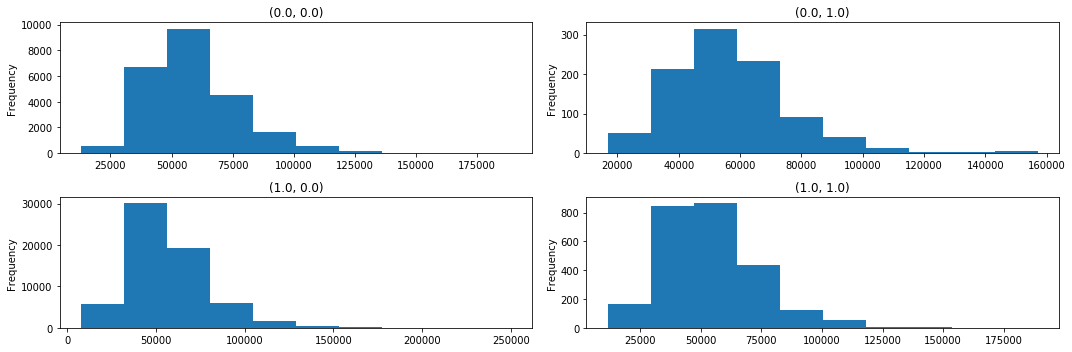

In [147]:
# Looking at histograms
keyslist = list(records12.groupby(['urban','sfha']).groups.keys())
grouped = records12.groupby(['urban','sfha'])
fig, axes = plt.subplots(2,2, figsize=(15,5))
for key, ax in zip(keyslist, axes.flatten()):
    grouped.get_group(key).median_household_income.plot(kind='hist', ax=ax, title = str(key))
    fig.tight_layout() 

In [148]:
# statistical test
print('For rural areas, are the median household income distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 0) & (records12.sfha == 0)].median_household_income,
            records12[(records12.urban == 0) & (records12.sfha == 1)].median_household_income)[1]<.05)
print('For urban areas, are the median household income distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 1) & (records12.sfha == 0)].median_household_income,
            records12[(records12.urban == 1) & (records12.sfha == 1)].median_household_income)[1]<.05)

For rural areas, are the median household income distribution different between the tracts where the flood prone homes are vs not?
True
For urban areas, are the median household income distribution different between the tracts where the flood prone homes are vs not?
True


Logistic regression analysis - controlling for being urban or not, is there a relationship between being in sfha and the median household income of the tract?

In [149]:
# defining the dependent and independent variables
Xtrain = records12[(pd.isna(records12.median_household_income) == False)][['median_household_income', 'urban']]
ytrain = records12[(pd.isna(records12.median_household_income) == False)][['sfha']]
   
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.175698
         Iterations 7


In [150]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                   sfha   No. Observations:                90465
Model:                          Logit   Df Residuals:                    90463
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Aug 2021   Pseudo R-squ.:                -0.07855
Time:                        16:29:25   Log-Likelihood:                -15894.
converged:                       True   LL-Null:                       -14737.
                                        LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
median_household_income -4.845e-05   4.72e-07   -102.685      0.000   -4.94e-05   -4.75e-05
urban                      -0.8548      0.029    -29.520      0.000      -0.912      -0.798


How do these tracts compare in the county?

In [151]:
# Descriptive stats
records12.groupby(['urban','sfha']).income_county_percentile_urban.describe()

count       mean        std       min        25%        50%  \
urban sfha                                                                  
0.0   0.0   23950.0  56.913908  28.150782  1.020408  33.333333  54.827993   
      1.0     968.0  54.407751  28.069896  1.162791  31.973422  51.388889   
1.0   0.0   63039.0  49.026157  26.411155  0.148662  27.659574  47.500000   
      1.0    2508.0  47.104919  26.065080  0.362319  25.806452  45.000000   

                  75%    max  
urban sfha                    
0.0   0.0   80.000000  100.0  
      1.0   76.219512  100.0  
1.0   0.0   69.354839  100.0  
      1.0   65.971800  100.0

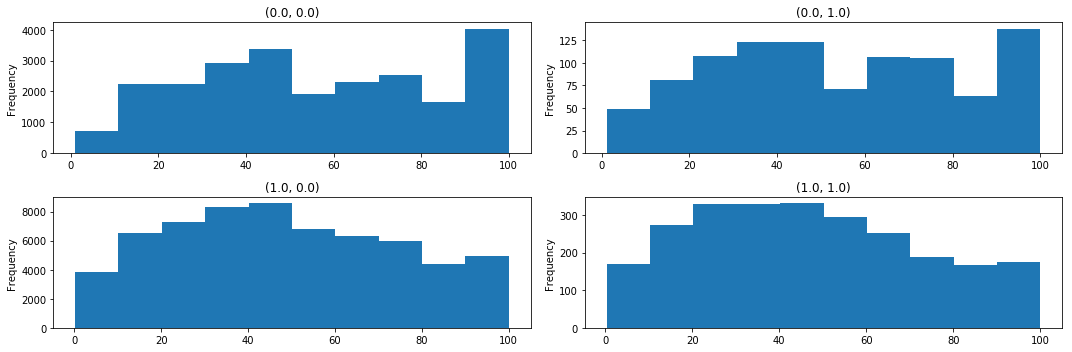

In [152]:
# Looking at histograms
keyslist = list(records12.groupby(['urban','sfha']).groups.keys())
grouped = records12.groupby(['urban','sfha'])
fig, axes = plt.subplots(2,2, figsize=(15,5))
for key, ax in zip(keyslist, axes.flatten()):
    grouped.get_group(key).income_county_percentile_urban.plot(kind='hist', ax=ax, title = str(key))
    fig.tight_layout() 

In [153]:
# statistical test
print('For rural areas, are the income percentile distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 0) & (records12.sfha == 0)].income_county_percentile_urban,
            records12[(records12.urban == 0) & (records12.sfha == 1)].income_county_percentile_urban)[1]<.05)
print('For urban areas, are the income percentile distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 1) & (records12.sfha == 0)].income_county_percentile_urban,
            records12[(records12.urban == 1) & (records12.sfha == 1)].income_county_percentile_urban)[1]<.05)

For rural areas, are the income percentile distribution different between the tracts where the flood prone homes are vs not?
True
For urban areas, are the income percentile distribution different between the tracts where the flood prone homes are vs not?
True


Looks like the tracts of SFHA HUD homes rank a little lower than non-SFHA ones

#### Looking state by state

In [154]:
# raw numbers
hud_homes_urban_incomelist = []

In [155]:
for state in list(records12.state.unique()):
    dicti = {}
    dicti['state'] = state
    try:
        f1,p1 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 1)].median_household_income, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 0)].median_household_income)
        f2,p2 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 1)].median_household_income, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 0)].median_household_income)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 1)].median_household_income.median()
        dicti['urban_non_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.median_household_income) == False) & 
                                            (records12.sfha == 0)].median_household_income.median()
        
        dicti['rural_sfha_median'] = records12[(records12.state == state)& 
                                                   (records12.urban == 0) & 
                                                   (pd.isna(records12.median_household_income) == False) & 
                                                   (records12.sfha == 1)].median_household_income.median()
        dicti['rural_non_sfha_median'] = records12[(records12.state == state)& 
                                           (records12.urban == 0) & 
                                           (pd.isna(records12.median_household_income) == False) & 
                                           (records12.sfha == 0)].median_household_income.median()
        hud_homes_urban_incomelist.append(dicti)
    except Exception:
        hud_homes_urban_incomelist.append(dicti)

In [156]:
hud_homes_urban_income_df = pd.DataFrame(hud_homes_urban_incomelist)

In [157]:
hud_homes_urban_income_df['urban_diff'] = hud_homes_urban_income_df.urban_non_sfha_median/hud_homes_urban_income_df.urban_sfha_median-1
hud_homes_urban_income_df['rural_diff'] = hud_homes_urban_income_df.rural_non_sfha_median/hud_homes_urban_income_df.rural_sfha_median-1
hud_homes_urban_income_df['urban_005'] = [True if x <.05 else False for x in hud_homes_urban_income_df.urban_p]
hud_homes_urban_income_df['rural_005'] = [True if x <.05 else False for x in hud_homes_urban_income_df.rural_p]

In [158]:
hud_homes_urban_income_df

,state,rural_p,urban_p,urban_sfha_median,urban_non_sfha_median,rural_sfha_median,rural_non_sfha_median,urban_diff,rural_diff,urban_005,rural_005
0,AL,0.307680,0.294736,45648.0,45938.0,52820.0,53854.0,0.006353,0.019576,False,False
1,AZ,0.280950,0.000207,42003.0,50494.0,46706.0,49819.5,0.202152,0.066662,True,False
2,AK,0.291184,0.436037,74167.0,79453.0,79435.0,75240.0,0.071272,-0.052810,False,False
3,AR,0.028205,0.104645,42645.0,48097.0,40926.0,46730.0,0.127846,0.141817,False,True
4,CA,0.143950,0.023881,52240.0,57727.5,55396.0,59701.0,0.105044,0.077713,True,False
5,CO,0.251898,0.273476,47570.0,52042.0,56172.0,59389.0,0.094009,0.057271,False,False
6,CT,0.038797,0.003387,62927.0,67108.0,61755.0,70952.0,0.066442,0.148927,True,True
7,DE,0.115329,0.299904,54273.0,57136.5,57866.0,67000.0,0.052761,0.157847,False,False
8,DC,0.000000,0.000000,NaN,58894.0,NaN,105434.0,NaN,NaN,True,True
9,FL,0.115728,0.346528,50019.0,49441.0,54051.0,54287.0,-0.011556,0.004366,False,False


In [159]:
# percentiles
hud_homes_urban_income_score_list = []

In [160]:
for state in list(records12.state.unique()):
    dicti = {}
    dicti['state'] = state
    try:
        f1,p1 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].income_county_percentile_urban, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].income_county_percentile_urban)
        f2,p2 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].income_county_percentile_urban, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].income_county_percentile_urban)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].income_county_percentile_urban.median()
        dicti['urban_non_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.income_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].income_county_percentile_urban.median()
        
        dicti['rural_sfha_median'] = records12[(records12.state == state)& 
                                                   (records12.urban == 0) & 
                                                   (pd.isna(records12.income_county_percentile_urban) == False) & 
                                                   (records12.sfha == 1)].income_county_percentile_urban.median()
        dicti['rural_non_sfha_median'] = records12[(records12.state == state)& 
                                           (records12.urban == 0) & 
                                           (pd.isna(records12.income_county_percentile_urban) == False) & 
                                           (records12.sfha == 0)].income_county_percentile_urban.median()
        hud_homes_urban_income_score_list.append(dicti)
    except Exception:
        hud_homes_urban_income_score_list.append(dicti)

In [161]:
hud_homes_urban_income_score_df = pd.DataFrame(hud_homes_urban_income_score_list)

In [162]:
hud_homes_urban_income_score_df['urban_diff'] = hud_homes_urban_income_score_df.urban_non_sfha_median/hud_homes_urban_income_score_df.urban_sfha_median-1
hud_homes_urban_income_score_df['rural_diff'] = hud_homes_urban_income_score_df.rural_non_sfha_median/hud_homes_urban_income_score_df.rural_sfha_median-1
hud_homes_urban_income_score_df['urban_005'] = [True if x <.05 else False for x in hud_homes_urban_income_score_df.urban_p]
hud_homes_urban_income_score_df['rural_005'] = [True if x <.05 else False for x in hud_homes_urban_income_score_df.rural_p]

In [163]:
hud_homes_urban_income_score_df

,state,rural_p,urban_p,urban_sfha_median,urban_non_sfha_median,rural_sfha_median,rural_non_sfha_median,urban_diff,rural_diff,urban_005,rural_005
0,AL,0.368608,3.248530e-01,55.844156,55.555556,60.000000,57.142857,-0.005168,-0.047619,False,False
1,AZ,0.064822,1.129736e-01,37.500000,47.058824,33.241379,50.000000,0.254902,0.504149,False,False
2,AK,0.224204,4.057654e-01,43.750000,50.531915,80.000000,62.500000,0.155015,-0.218750,False,False
3,AR,0.004707,2.689299e-01,51.973684,55.263158,33.333333,60.000000,0.063291,0.800000,False,True
4,CA,0.478913,6.685190e-02,31.395349,44.315245,38.372093,50.000000,0.411523,0.303030,False,False
5,CO,0.183205,2.521611e-01,33.333333,45.916667,50.000000,60.000000,0.377500,0.200000,False,False
6,CT,0.162402,4.803998e-04,32.075472,40.000000,28.571429,40.000000,0.247059,0.400000,True,False
7,DE,0.109319,3.327715e-01,35.746606,38.235294,20.000000,42.857143,0.069620,1.142857,False,False
8,DC,0.000000,0.000000e+00,NaN,35.389610,NaN,50.000000,NaN,NaN,True,True
9,FL,0.187920,6.328427e-04,44.262295,47.368421,48.137931,50.000000,0.070175,0.038682,True,False


### Percentage of white non-Hispanic residents

In [164]:
# Looking at descriptive stats
records12.groupby(['urban','sfha']).white_pct.describe()

count      mean       std  min       25%       50%       75%  \
urban sfha                                                                   
0.0   0.0   23954.0  0.713546  0.255905  0.0  0.580593  0.798180  0.920271   
      1.0     968.0  0.644926  0.295620  0.0  0.456265  0.736641  0.890598   
1.0   0.0   64537.0  0.596540  0.302999  0.0  0.365750  0.677408  0.859346   
      1.0    2508.0  0.581088  0.302911  0.0  0.328304  0.644489  0.850956   

                 max  
urban sfha            
0.0   0.0   1.000000  
      1.0   1.000000  
1.0   0.0   1.000000  
      1.0   0.996467

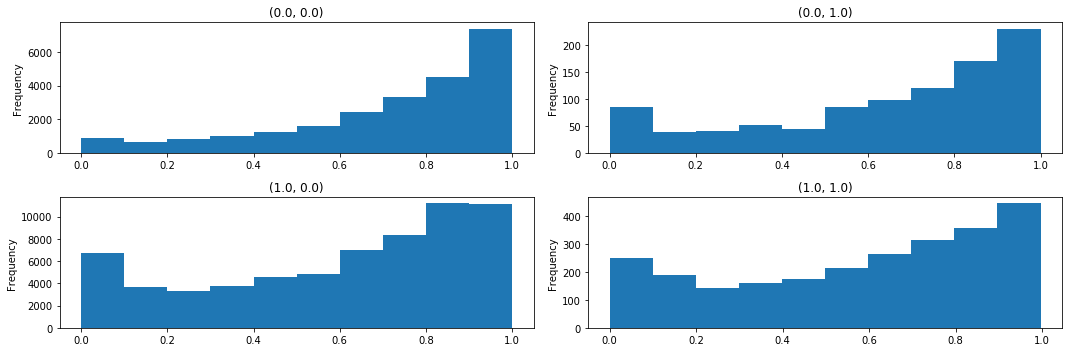

In [165]:
# Looking at histograms
keyslist = list(records12.groupby(['urban','sfha']).groups.keys())
grouped = records12.groupby(['urban','sfha'])
fig, axes = plt.subplots(2,2, figsize=(15,5))
for key, ax in zip(keyslist, axes.flatten()):
    grouped.get_group(key).white_pct.plot(kind='hist', ax=ax, title = str(key))
    fig.tight_layout() 

It seems that homes that are in SFHAs are in Census tracts with slightly lower percentage of white residents than HUD homes not in SFHAS.

In [166]:
# statistical test
print('For rural areas, are the white pct distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 0) & (records12.sfha == 0)].white_pct,
            records12[(records12.urban == 0) & (records12.sfha == 1)].white_pct)[1]<.05)
print('For urban areas, are the white pct distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 1) & (records12.sfha == 0)].white_pct,
            records12[(records12.urban == 1) & (records12.sfha == 1)].white_pct)[1]<.05)

For rural areas, are the white pct distribution different between the tracts where the flood prone homes are vs not?
True
For urban areas, are the white pct distribution different between the tracts where the flood prone homes are vs not?
True


In [167]:
# defining the dependent and independent variables
Xtrain = records12[(pd.isna(records12.white_pct) == False)][['white_pct', 'urban']]
ytrain = records12[(pd.isna(records12.white_pct) == False)][['sfha']]
   
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.186666
         Iterations 8


In [168]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                   sfha   No. Observations:                91967
Model:                          Logit   Df Residuals:                    91965
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Aug 2021   Pseudo R-squ.:                 -0.1603
Time:                        16:29:36   Log-Likelihood:                -17167.
converged:                       True   LL-Null:                       -14795.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
white_pct     -3.3091      0.031   -105.826      0.000      -3.370      -3.248
urban         -1.7680      0.023    -77.175      0.000      -1.813      -1.723


Hmmm...not sure it worked

How do the tracts of HUD homes rank in white percentage compare to other tracts in the same county?

In [169]:
# Descriptive stats
records12.groupby(['urban','sfha']).white_county_percentile_urban.describe()

count       mean        std       min        25%        50%  \
urban sfha                                                                  
0.0   0.0   23954.0  56.301463  28.982127  0.609756  33.333333  53.846154   
      1.0     968.0  54.151117  29.008120  1.219512  31.707317  50.000000   
1.0   0.0   64537.0  49.502847  28.237097  0.288184  25.531915  47.605634   
      1.0    2508.0  50.659340  28.375829  0.422535  26.632653  50.000000   

                  75%    max  
urban sfha                    
0.0   0.0   80.000000  100.0  
      1.0   78.571429  100.0  
1.0   0.0   72.500000  100.0  
      1.0   73.953301  100.0

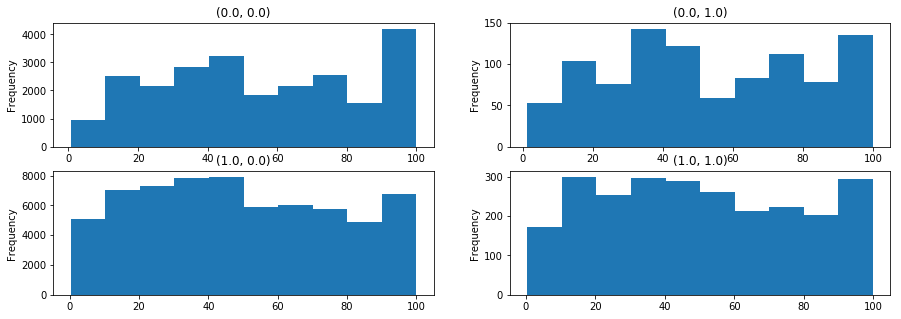

In [170]:
# Looking at histograms
keyslist = list(records12.groupby(['urban','sfha']).groups.keys())
grouped = records12.groupby(['urban','sfha'])
fig, axes = plt.subplots(2,2, figsize=(15,5))
for key, ax in zip(keyslist, axes.flatten()):
    grouped.get_group(key).white_county_percentile_urban.plot(kind='hist', ax=ax, title = str(key))

see percentile

In [171]:
# statistical test
print('For rural areas, are the white pct percentile distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 0) & (records12.sfha == 0)].white_county_percentile_urban,
            records12[(records12.urban == 0) & (records12.sfha == 1)].white_county_percentile_urban)[1]<.05)
print('For urban areas, are the white pct percentile distribution different between the tracts where the flood prone homes are vs not?')
print (mannwhitneyu(records12[(records12.urban == 1) & (records12.sfha == 0)].white_county_percentile_urban,
            records12[(records12.urban == 1) & (records12.sfha == 1)].white_county_percentile_urban)[1]<.05)

For rural areas, are the white pct percentile distribution different between the tracts where the flood prone homes are vs not?
True
For urban areas, are the white pct percentile distribution different between the tracts where the flood prone homes are vs not?
True


state by state

In [172]:
# raw numbers
hud_homes_urban_racelist = []

In [173]:
for state in list(records12.state.unique()):
    dicti = {}
    dicti['state'] = state
    try:
        f1,p1 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 1)].white_pct, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 0)].white_pct)
        f2,p2 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 1)].white_pct, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 0)].white_pct)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 1)].white_pct.median()
        dicti['urban_non_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_pct) == False) & 
                                            (records12.sfha == 0)].white_pct.median()
        
        dicti['rural_sfha_median'] = records12[(records12.state == state)& 
                                                   (records12.urban == 0) & 
                                                   (pd.isna(records12.white_pct) == False) & 
                                                   (records12.sfha == 1)].white_pct.median()
        dicti['rural_non_sfha_median'] = records12[(records12.state == state)& 
                                           (records12.urban == 0) & 
                                           (pd.isna(records12.white_pct) == False) & 
                                           (records12.sfha == 0)].white_pct.median()
        hud_homes_urban_racelist.append(dicti)
    except Exception:
        hud_homes_urban_racelist.append(dicti)

In [174]:
hud_homes_urban_race_df = pd.DataFrame(hud_homes_urban_racelist)

In [175]:
hud_homes_urban_race_df['urban_diff'] = hud_homes_urban_race_df.urban_non_sfha_median-hud_homes_urban_race_df.urban_sfha_median
hud_homes_urban_race_df['rural_diff'] = hud_homes_urban_race_df.rural_non_sfha_median-hud_homes_urban_race_df.rural_sfha_median
hud_homes_urban_race_df['urban_005'] = [True if x <.05 else False for x in hud_homes_urban_race_df.urban_p]
hud_homes_urban_race_df['rural_005'] = [True if x <.05 else False for x in hud_homes_urban_race_df.rural_p]

In [176]:
hud_homes_urban_race_df

,state,rural_p,urban_p,urban_sfha_median,urban_non_sfha_median,rural_sfha_median,rural_non_sfha_median,urban_diff,rural_diff,urban_005,rural_005
0,AL,3.233137e-01,1.029127e-01,0.535055,0.592329,0.814397,0.800043,0.057273,-0.014353,False,False
1,AZ,4.082655e-01,4.444676e-05,0.428079,0.646049,0.727684,0.721400,0.217970,-0.006284,True,False
2,AK,7.068072e-02,4.637105e-02,0.849640,0.595584,0.719683,0.772340,-0.254057,0.052657,True,False
3,AR,3.009750e-01,3.952921e-01,0.687636,0.646528,0.883369,0.897436,-0.041108,0.014067,False,False
4,CA,3.761604e-01,1.526732e-01,0.534653,0.444599,0.445105,0.484616,-0.090055,0.039510,False,False
5,CO,2.008593e-01,4.960913e-02,0.757187,0.644503,0.766486,0.788722,-0.112684,0.022236,True,False
6,CT,4.821460e-01,1.011244e-02,0.599223,0.665524,0.851570,0.797511,0.066301,-0.054059,True,False
7,DE,7.516046e-02,4.855225e-01,0.584715,0.527390,0.932665,0.635791,-0.057325,-0.296873,False,False
8,DC,0.000000e+00,0.000000e+00,NaN,0.093885,NaN,0.570730,NaN,NaN,True,True
9,FL,5.071927e-12,7.127005e-06,0.500575,0.629573,0.446908,0.696480,0.128998,0.249572,True,True


In [177]:
# percentiles
hud_homes_urban_white_pct_score_list = []

In [178]:
for state in list(records12.state.unique()):
    dicti = {}
    dicti['state'] = state
    try:
        f1,p1 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].white_county_percentile_urban, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 0) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].white_county_percentile_urban)
        f2,p2 = mannwhitneyu(records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].white_county_percentile_urban, 
                             records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].white_county_percentile_urban)
        dicti['rural_p'] = p1
        dicti['urban_p'] = p2
        dicti['urban_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 1)].white_county_percentile_urban.median()
        dicti['urban_non_sfha_median'] = records12[(records12.state == state)& 
                                            (records12.urban == 1) & 
                                            (pd.isna(records12.white_county_percentile_urban) == False) & 
                                            (records12.sfha == 0)].white_county_percentile_urban.median()
        
        dicti['rural_sfha_median'] = records12[(records12.state == state)& 
                                                   (records12.urban == 0) & 
                                                   (pd.isna(records12.white_county_percentile_urban) == False) & 
                                                   (records12.sfha == 1)].white_county_percentile_urban.median()
        dicti['rural_non_sfha_median'] = records12[(records12.state == state)& 
                                           (records12.urban == 0) & 
                                           (pd.isna(records12.white_county_percentile_urban) == False) & 
                                           (records12.sfha == 0)].white_county_percentile_urban.median()
        hud_homes_urban_white_pct_score_list.append(dicti)
    except Exception:
        hud_homes_urban_white_pct_score_list.append(dicti)

In [179]:
hud_homes_urban_white_pct_score_df = pd.DataFrame(hud_homes_urban_white_pct_score_list)

In [180]:
hud_homes_urban_white_pct_score_df['urban_diff'] = hud_homes_urban_white_pct_score_df.urban_non_sfha_median/hud_homes_urban_white_pct_score_df.urban_sfha_median-1
hud_homes_urban_white_pct_score_df['rural_diff'] = hud_homes_urban_white_pct_score_df.rural_non_sfha_median/hud_homes_urban_white_pct_score_df.rural_sfha_median-1
hud_homes_urban_white_pct_score_df['urban_005'] = [True if x <.05 else False for x in hud_homes_urban_white_pct_score_df.urban_p]
hud_homes_urban_white_pct_score_df['rural_005'] = [True if x <.05 else False for x in hud_homes_urban_white_pct_score_df.rural_p]

In [181]:
hud_homes_urban_white_pct_score_df

,state,rural_p,urban_p,urban_sfha_median,urban_non_sfha_median,rural_sfha_median,rural_non_sfha_median,urban_diff,rural_diff,urban_005,rural_005
0,AL,0.413682,0.231836,54.954042,53.333333,65.217391,54.545455,-0.029492,-0.163636,False,False
1,AZ,0.345569,0.001814,40.487805,58.333333,54.960317,56.250000,0.440763,0.023466,True,False
2,AK,0.131484,0.081030,93.750000,44.680851,40.000000,60.000000,-0.523404,0.500000,False,False
3,AR,0.110713,0.459876,54.887218,54.545455,50.000000,66.666667,-0.006227,0.333333,False,False
4,CA,0.266708,0.295264,61.521739,54.954516,67.692308,58.461538,-0.106746,-0.136364,False,False
5,CO,0.451929,0.108178,66.666667,43.237082,47.222222,50.000000,-0.351444,0.058824,False,False
6,CT,0.253467,0.278539,34.871795,40.000000,64.285714,50.000000,0.147059,-0.222222,False,False
7,DE,0.083634,0.477632,34.942182,33.270488,85.000000,30.000000,-0.047842,-0.647059,False,False
8,DC,0.000000,0.000000,NaN,35.389610,NaN,38.000000,NaN,NaN,True,True
9,FL,0.267385,0.069143,40.000000,43.658671,45.894309,46.247655,0.091467,0.007699,False,False


Trying different models with both race and income

In [182]:
records12_1 = records12.copy()

In [183]:
records12_1.state1 = records12_1.state1.astype(float)
records12_1.county1 = records12_1.county1.astype(float)

In [184]:
# defining the dependent and independent variables
Xtrain = records12_1[(pd.isna(records12_1.white_pct) == False) & (pd.isna(records12_1.median_household_income) == False)][['white_pct','median_household_income']]
ytrain = records12_1[(pd.isna(records12_1.white_pct) == False) & (pd.isna(records12_1.median_household_income) == False)][['sfha']]
   
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.177948
         Iterations 8


In [185]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                   sfha   No. Observations:                90465
Model:                          Logit   Df Residuals:                    90463
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Aug 2021   Pseudo R-squ.:                -0.09236
Time:                        16:29:45   Log-Likelihood:                -16098.
converged:                       True   LL-Null:                       -14737.
                                        LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
white_pct                  -1.1181      0.053    -21.212      0.000      -1.221      -1.015
median_household_income -4.707e-05   6.63e-07    -70.988      0.000   -4.84e-05   -4.58e-05


In [186]:
# defining the dependent and independent variables
Xtrain = records12_1[(pd.isna(records12_1.white_county_percentile_urban) == False) &
                    (pd.isna(records12_1.income_county_percentile_urban) == False) ][['white_county_percentile_urban','income_county_percentile_urban']]
ytrain = records12_1[(pd.isna(records12_1.white_county_percentile_urban) == False) & 
                    (pd.isna(records12_1.income_county_percentile_urban) == False) ][['sfha']]
   
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.214095
         Iterations 7


In [187]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                   sfha   No. Observations:                90465
Model:                          Logit   Df Residuals:                    90463
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Aug 2021   Pseudo R-squ.:                 -0.3143
Time:                        16:29:46   Log-Likelihood:                -19368.
converged:                       True   LL-Null:                       -14737.
                                        LLR p-value:                     1.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
white_county_percentile_urban     -0.0252      0.001    -40.165      0.000      -0.026      -0.024
income_county_percentile_urban    -0.0416      0.001    -60.902      0.

P value is high so the model doesn't mean much. https://investigate.ai/regression/evaluating-logistic-regressions/<br>
This seems to suggest that while there is a difference beteween race and income for HUD homes in flood zones vs. not in flood zones, these two variables are poor indicators of whether a HUD home is in a flood zone or not